In [6]:
## Import libraries
from datetime import datetime
from dateutil.relativedelta import relativedelta
import xarray as xr
from glob import glob
import numpy as np
from pathlib import Path

In [7]:
## Settings

# Valid regions and their mapping to axis extents in [W, E, S, N] format 
# as well as timezones in hour +- GMT
regions = {
    # Central America (mostly Honduras-Nicaragua-Costa Rica)
    "ca": {"extent": [-91, -81, 7, 17], "tz": -6},
    # South America (mostly eastern Brazil)
    "sa": {"extent": [-65, -30, -15, 0], "tz": -3},
    # Western Australia (mostly near the west coast)
    "wa": {"extent": [113, 123, -35, -30], "tz": +8}
}

# Earliest and latest entries in each GLASS dataset
avhrr_earliest = "Jan-1981"
modis_earliest = "Mar-2000"
avhrr_latest = "Dec-2018"
modis_latest = "Dec-2021"
fapar_earliest = "Jan-1982"
fapar_latest = "Dec-2020"

# Size of chunks
chunksize = "500MB"

# Valid subsets to use as argument in climatologies and
# their mapping to month numbers for use in xarray time slicing
subsets = {
    "all": [1,2,3,4,5,6,7,8,9,10,11,12],
    "DJF": [12,1,2], "MAM": [3,4,5], "JJA": [6,7,8], "SON": [9,10,11],
    "Jan": [1], "Feb": [2], "Mar": [3], "Apr": [4], "May": [5], "Jun": [6],
    "Jul": [7], "Aug": [8], "Sep": [9], "Oct": [10], "Nov": [11], "Dec": [12]
}

# Valid variables for use in analysis
vars_glass = ["lai", "fapar"]
vars_era5 = ["ws10", "dws10", "ws100", "dws100", "mslp", "dmslp",
             "t2", "dt2", "lhf", "dlhf", "shf", "dshf"]
hours = list(range(0, 24))

# File number check to make sure data_download notebook was run correctly
number_of_glass_files = {"lai": {"avhrr": 1748, "modis": 1005},
                         "fapar": {"avhrr": 1702, "modis": 960}
                        }

In [8]:
## Define functions

def check_args(region=None, periodstart=None, periodend=None,
               subset=None, var=None, hour=None, outputpath=None):
    
    """
    Function to check whether input arguments are valid.
    
    Arguments:
        region (str)
        periodstart (datetime.datetime)
        periodend (datetime.datetime)
        subset (str)
        var (str)
        hour (int)
        outputpath (str)
    
    An assertion error will be raised if any of these arguments are invalid.
    """
    
    if region:
        assert region in [*regions], \
            f"region must be one of: {[*regions]}"
    if periodstart:
        assert periodstart >= datetime.strptime(avhrr_earliest, "%b-%Y"), \
            f"periodstart must be equal to or later than {avhrr_earliest}"        
    if periodend:
        assert periodend <= datetime.strptime(modis_latest, "%b-%Y"), \
            f"periodend must be equal to or earlier than {modis_latest}"
    if (periodstart is not None) & (periodend is not None):
        assert periodend >= periodstart, \
            "periodend must be equal to or later than periodstart"        
    if subset:
        assert subset in [*subsets], \
            f"subset must be one of: {[*subsets]}"
    if var:
        assert var in vars_era5, \
            f"var must be one of: {vars_era5}"
    if hour:
        assert hour in hours, \
            f"hour must be one of: {hours}"
    if outputpath:
        assert Path(outputpath).exists() == False, \
            f"File with name already exists: {outputpath}"

In [9]:
def glass_data_source_to_use(periodstart, periodend):
    
    """
    Select which GLASS data source (AVHRR or MODIS) to use
    
    Arguments:
        periodstart (datetime.datetime): Start of period coverage
        periodend (datetime.datetime): End of period coverage
        
    Returns:
        data_source (str): String indicating whether to use
                            "avhrr" or "modis" data for the given period
    
    For the given period, select the most appropriate GLASS data source to use 
    (out of AVHRR and MODIS). MODIS is preferentially selected where the given 
    period is completely contained within the time range of MODIS data. 
    Otherwise, AVHRR data is used. Periods which simultaneously cover both an 
    AVHRR-only period (i.e. before Mar-2000) and a MODIS-only period 
    (i.e. after Dec-2018) are prevented from selection since summary statistics
    over this range is subject to artefacts from the change in instruments.
    """
    
    assert periodstart >= datetime.strptime(avhrr_earliest, "%b-%Y"), \
        f"periodstart must be equal to or later than {avhrr_earliest}"
    assert periodend <= datetime.strptime(modis_latest, "%b-%Y"), \
        f"periodend must be equal to or earlier than {modis_latest}"
    assert periodend >= periodstart, \
        "periodend must be equal to or later than periodstart"  
    
    if ((periodstart >= datetime.strptime(avhrr_earliest, "%b-%Y")) & 
        (periodstart < datetime.strptime(modis_earliest, "%b-%Y")) &
        (periodend <= datetime.strptime(avhrr_latest, "%b-%Y"))
       ):
        data_source = "avhrr"
    elif ((periodstart >= datetime.strptime(modis_earliest, "%b-%Y")) &
          (periodend <= datetime.strptime(modis_latest, "%b-%Y"))
         ):
        data_source = "modis"
    else:
        raise Exception("If periodstart is before Mar-2000, " +
                        "periodend cannot be after Dec-2018 " +
                        "(since this would cover both an " +
                        "AVHRR-only and a MODIS-only period)")
        
    return(data_source)

In [10]:
def calc_glass_mean_climatology(region, periodstart, periodend, subset):
    
    """
    Calculate mean leaf area index (MLAI) and mean fraction of absorbed
    photosynthetically active radiation (MFAPAR) climatology using GLASS data
    
    Arguments:
        region (str): Region to perform calculation over.
                        Must be one of ["ca", "sa", "wa"].
        periodstart (str): Start of period to perform calculation over.
                        Must be of form "%b-%Y" eg. "Jul-1990".
                        Must be between "Jan-1981" and "Dec-2021".
        periodend (str): End of period to perform calculation over.
                        Must be of form "%b-%Y" eg. "Jul-1990".
                        Must be between "Jan-1981" and "Dec-2021".
        subset (str): Subset of period to perform calculation over.
                        Must be one of ["all", "DJF", "MAM", "JJA", "SON",
                        "Jan", "Feb", "Mar", "Apr", "May", "Jun",
                        "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"].
                        
    Returns:
        {region}_{periodstart}_{periodend}_{subset}_glass-mean_{datasource}.nc:
                        Output netcdf4 file in data_processed file containing both 
                        MLAI and MFAPAR. {datasource} is automatically selected 
                        between ["avhrr", "modis"] based on selected period.
    
    For each grid cell, calculate the mean glass climatology (MLAI or MFAPAR) over 
    the period from periodstart to periodend (inclusive). The calculation uses 
    8-day satellite HDF data from the data_raw folder as input, then outputs 
    the result as a netcdf4 file into the data_processed folder. MODIS data
    is preferentially used where the given period is completely contained 
    within the time range of MODIS data. Otherwise, AVHRR data is used.
    """
    
    # Assert that there are no errors in input arguments, and select the
    # appropriate data source (AVHRR or MODIS) to use depending on period
    periodstart = datetime.strptime(periodstart, "%b-%Y")
    periodend = datetime.strptime(periodend, "%b-%Y")
    datasource = glass_data_source_to_use(periodstart, periodend)
    outputpath = ("../data_processed/{}_{}_{}_{}_glass-mean_{}.nc"
                  .format(region, periodstart.strftime("%b-%Y"),
                          periodend.strftime("%b-%Y"), subset, datasource)
                 )
    check_args(region=region, periodstart=periodstart, periodend=periodend,
               subset=subset, outputpath=outputpath)

    # The two functions below are used with xarray's open_mfdataset for parallel
    # computing using dask. The region and times (period and subset) are
    # selected within separate functions and uses different logic as compared with
    # filtering in the ERA5 datasets. This is because each GLASS file contains
    # global data whereas the ERA5 datasets were downloaded for each local region.
    
    def filter_glass_files(file):
        # This function is used as a mask in conjunction with the default python
        # filter function later, in order to select out the raw data files within
        # the input period and climatological subset within the original function 
        # arguments (by using dates contained within each file name). This is done 
        # (as opposed to using open_mfdataset then filtering) for scalability reasons 
        # since we may need to persist the data in RAM to speed up certain computations.
        time = file[-12:-4]
        time = datetime.strptime(time, "%Y-%j")
        if ((time.month in subsets[subset]) &
            # We add an extra month to periodend here because periodend was
            # specified as a month, and conversion into a datetime object
            # defaults to the first (rather than last) day of that month
            (periodstart <= time < periodend + relativedelta(months=1))
           ):
            return(True)
        else:
            return(False)
    
    def preprocess_glass(ds):
        # This function is used for the preprocess argument in open_mfdataset.
        # It uses the dates in each raw data file name to assign a time dimension
        # and coordinate for the corresponding dataset. This then forms the
        # dimension along which the files are combined into a single dataset
        # and rechunked. This function also selects out the input region within
        # the original function arguments before the files are concatenated using
        # open_mfdataset (this is again done for persist scalability).
        time = ds.encoding["source"][-12:-4]
        time = datetime.strptime(time, "%Y-%j")
        ds = (ds
              .expand_dims({"time": [time]})
              # Redundant measure just in case longitudes exceed 180 degrees
              .assign_coords({"x": (ds.x + 180) % 360 - 180})
              .sortby("x")
              .rename({"x": "longitude", "y": "latitude"})
              )
        return(ds.sel(longitude=slice(regions[region]["extent"][0],
                                      regions[region]["extent"][1]),
                      latitude=slice(regions[region]["extent"][3],
                                     regions[region]["extent"][2]))
              )
    
    # The following code creates the mean climatology datasets for each GLASS
    # variable, by using the previous functions along with open_mfdataset.
    # An initally empty dataset is iteratively appended then merged so that
    # future scalability is possible in case one wishes to add more GLASS
    # variables to the vars_glass global python variable.
    datasets = []    
    for var in vars_glass:
        files_all = glob(f"../data_raw/global_glass-{var}-{datasource}_8-day/" +
                             f"global_glass-{var}-{datasource}*")
        if len(files_all) != number_of_glass_files[var][datasource]:
            print(f"Warning: Expected {number_of_glass_files[var][datasource]} " +
                  f"files in ../data_raw/global_glass-{var}-{datasource}_8-day/ " +
                  f"but got {len(files_all)}. This could be because the " + 
                  "data_download.ipynb notebook was not run properly. Or it " +
                  "could be that the number of GLASS files on the server " +
                  "from which the data was downloaded has changed.")
        files_filtered = list(filter(filter_glass_files, files_all))
        files_filtered.sort()
        # The if statement is to ensure an array full of NaNs is returned for MFAPAR
        # when the input period includes 1981 or 2021. At the time of writing, GLASS
        # FAPAR data is not available for these years.
        if (var == "fapar") & (
            (periodstart < datetime.strptime(fapar_earliest, "%b-%Y")) |
            (periodend > datetime.strptime(fapar_latest, "%b-%Y"))):
            # This line exploits the fact that the for loop runs in sequence and 
            # will have computed MLAI before it attempts to compute MFAPAR. 
            # Therefore an MLAI array with appropriate coordinates already exists 
            # in the datasets list and can be used to create an array of NaNs.
            ds_mean = (datasets[0]
                       .where(np.isnan(datasets[0]["lai"]))
                       .rename({"lai": var})
                      )
            print("Warning: GLASS FAPAR data is not available for the years " +
                  f"{fapar_earliest[-4:]} and {fapar_latest[-4:]}. " +
                  "A data array with NaNs was returned for MFAPAR instead.")
        else:
            ds_mean = (xr.open_mfdataset(files_filtered, engine = "rasterio",
                                         preprocess=preprocess_glass, parallel = True)
                       # Rechunking after open_mfdataset here is actually bad practice
                       # since it uses more RAM, but the chunks argument for
                       # open_mfdataset doesn't seem to work here for some reason
                       .chunk(chunks = {"time": chunksize})
                       .persist()
                       .drop_vars("spatial_ref")
                       .squeeze("band", drop=True)
                       .rename({"band_data": var})
                       .mean("time")
                      )
        datasets.append(ds_mean)
    ds_glass_mean = xr.merge(datasets)
    
    # Create output file in data_processed folder
    try:
        ds_glass_mean.to_netcdf(outputpath)
        print("Created " + outputpath)
    except:
        print("Failed to create " + outputpath)

In [12]:
%%time
calc_glass_mean_climatology("wa", "Jun-2000", "Aug-2005", "JJA")

Created ../data_processed/wa_Jun-2000_Aug-2005_JJA_glass-mean_modis.nc
CPU times: user 21.6 s, sys: 7.42 s, total: 29 s
Wall time: 25.9 s


In [ ]:
def calc_era5_weibull_climatology(region, periodstart, periodend, subset):

    """
    Calculate climatology of Weibull scale and shape parameters for wind speeds
    at 10 m and 100 m above surface using ERA5 data
    
    Arguments:
        region (str): Region to perform calculation over.
                        Must be one of ["ca", "sa", "wa"].
        periodstart (str): Start of period to perform calculation over.
                        Must be of form "%b-%Y" eg. "Jul-1990".
                        Must be between "Jan-1981" and "Dec-2021".
        periodend (str): End of period to perform calculation over.
                        Must be of form "%b-%Y" eg. "Jul-1990".
                        Must be between "Jan-1981" and "Dec-2021".
        subset (str): Subset of period to perform calculation over.
                        Must be one of ["all", "DJF", "MAM", "JJA", "SON",
                        "Jan", "Feb", "Mar", "Apr", "May", "Jun",
                        "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"].
                        
    Returns:
        {region}_{periodstart}_{periodend}_{subset}_era5-weibull.nc:
                        Output netcdf4 file in data_processed file containing
                        Weibull shape and scale parameters for wind speed
                        at 10 m and 100 m above surface.
    
    For each grid cell, calculate the Weibull shape and scale parameters over 
    the period from periodstart to periodend (inclusive). The calculation uses 
    hourly ERA5 netcdf4 data from the data_raw folder as input, then outputs 
    the result as a netcdf4 file into the data_processed folder.
    """
    
    # Assert that there are no errors in input arguments
    periodstart = datetime.strptime(periodstart, "%b-%Y")
    periodend = datetime.strptime(periodend, "%b-%Y")
    outputpath = ("../data_processed/{}_{}_{}_{}_era5-weibull.nc"
                  .format(region, periodstart.strftime("%b-%Y"),
                          periodend.strftime("%b-%Y"), subset)
                 )
    check_args(region=region, periodstart=periodstart, periodend=periodend,
               subset=subset, outputpath=outputpath)
    
    

In [5]:
from dask.distributed import Client
client = Client()
client

2022-08-19 16:25:49,932 - distributed.diskutils - INFO - Found stale lock file and directory '/home/anthony/Thesis/test/dask-worker-space/worker-1r7uaro6', purging
2022-08-19 16:25:49,932 - distributed.diskutils - INFO - Found stale lock file and directory '/home/anthony/Thesis/test/dask-worker-space/worker-33ofxd1l', purging
2022-08-19 16:25:49,933 - distributed.diskutils - INFO - Found stale lock file and directory '/home/anthony/Thesis/test/dask-worker-space/worker-qo0gto71', purging
2022-08-19 16:25:49,933 - distributed.diskutils - INFO - Found stale lock file and directory '/home/anthony/Thesis/test/dask-worker-space/worker-gitbx460', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 15.48 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36421,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 15.48 GiB
Comm: tcp://127.0.0.1:33269,Total threads: 3
Dashboard: http://127.0.0.1:46465/status,Memory: 3.87 GiB
Nanny: tcp://127.0.0.1:38731,


In [12]:
client.close()

In [6]:
calc_mlai_climatology?

Signature:
calc_mlai_climatology(
    region,
    periodstart,
    periodend,
    subset,
    outputname=None,
)
Docstring:
Calculate mean leaf area index (MLAI) climatology

Arguments:
    region (str): Region to perform calculation over.
                    Must be one of ["ca", "sa", "wa"]
    periodstart (str): Start of period to perform calculation over.
                    Must be of form "%b-%Y" eg. "Jul-1990".
                    Must be between "Jan-1981" and "Dec-2021".
    periodend (str): End of period to perform calculation over.
                    Must be of form "%b-%Y" eg. "Jul-1990".
                    Must be between "Jan-1981" and "Dec-2021".
    subset (str): Subset of period to perform calculation over.
                    Must be one of ["all", "DJF", "MAM", "JJA", "SON",
                    "Jan", "Feb", "Mar", "Apr", "May", "Jun",
                    "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
    outputname (str): Name of output netcdf4 file. If none is
       

In [ ]:
# subsets = ["all", "DJF", "MAM", "JJA", "SON",
#            "Jan", "Feb", "Mar", "Apr", "May", "Jun",
#            "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

In [ ]:
# months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
#           "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
# years = range(1981, 2022)

In [ ]:
    # assert(isinstance(periodstart, str)), {"periodstart must be a string " +
    #                                       "of form '%b-%Y' eg. Jul-1990"}
    # assert(len(periodstart)==8), {"periodstart must be a string " +
    #                               "of form '%b-%Y' eg. Jul-1990"}
    # assert(periodstart[3]=="-"), {"periodstart must be a string " +
    #                               "of form '%b-%Y' eg. Jul-1990"}
    # assert(periodstart[0:3] in months), {"periodstart must be a string " +
    #                                      "of form '%b-%Y' eg. Jul-1990"}
    # assert(int(periodstart[4:8]) in years), {"periodstart must be a string " +
    #                                          "of form '%b-%Y' eg. Jul-1990"}

In [ ]:
def preprocess_glass(ds):
    """
    Preprocess GLASS dataset for opening using xarray.open_mfdataset
    
    Arguments:
        ds (xarray.Dataset): Dataset for preprocessing
        
    Returns:
        
    """
    time = ds.encoding["source"][-12:-4]
    time = datetime.strptime(time, "%Y-%j")
    ds = (ds
          .expand_dims({"time": [time]})
          .assign_coords({"x": (ds.x + 180) % 360 - 180})
          .sortby("x")
          .rename({"x": "longitude", "y": "latitude"})
          )
    return(ds.sel(longitude=slice(regions[region]["extent"][0],
                                  regions[region]["extent"][1]),
                  latitude=slice(regions[region]["extent"][3],
                                 regions[region]["extent"][2])))

SyntaxError: no binding for nonlocal 'region' found (2315640921.py, line 11)

In [45]:
lai_files = glob("../data_raw/global_glass-lai-avhrr_8-day/global_glass-lai-avhrr_8-day_1981*")
lai_files.sort()

In [70]:
dset = xr.open_mfdataset(lai_files, engine = "rasterio", preprocess=preprocess_glass).chunk(chunks = {"time": files_in_glass_chunk})
dset["band_data"]
# select region

# select period and subset month within lai_files instead?
# select period
# try sel month [1,2,3]
# create subset dict mapping names to list of numbers
# select subset
# ds = ds.sel(time = ds["time.month"] in subsets[subset])? - will this work for individual datasets instead of open_mfdataset? Should return empty array instead?

# docstring preprocess
# automate data_source in lai_files
# define separate function to check argument validity?

TypeError: preprocess_glass() missing 1 required positional argument: 'region'

In [45]:
lai_files_all = glob(f"../data_raw/global_glass-lai-avhrr_8-day/global_glass-lai-avhrr_8-day_198*")
# times = [file[-12:-4] for file in lai_files_all]

subset = "JJA"
periodstart = "Jul-1985"
periodend = "Aug-1990"
periodstart = datetime.strptime(periodstart, "%b-%Y")
periodend = datetime.strptime(periodend, "%b-%Y")

def lai_files_filter(file):
    time = file[-12:-4]
    time = datetime.strptime(time, "%Y-%j")
    if (time.month in subsets[subset]) & (periodstart <= time <= periodend):
        return(True)
    else:
        return(False)

lai_files_filtered = list(filter(lai_files_filter, lai_files_all))
lai_files_filtered.sort()
from pprint import pprint
pprint(lai_files_filtered)

['../data_raw/global_glass-lai-avhrr_8-day/global_glass-lai-avhrr_8-day_1985-185.hdf',
 '../data_raw/global_glass-lai-avhrr_8-day/global_glass-lai-avhrr_8-day_1985-193.hdf',
 '../data_raw/global_glass-lai-avhrr_8-day/global_glass-lai-avhrr_8-day_1985-201.hdf',
 '../data_raw/global_glass-lai-avhrr_8-day/global_glass-lai-avhrr_8-day_1985-209.hdf',
 '../data_raw/global_glass-lai-avhrr_8-day/global_glass-lai-avhrr_8-day_1985-217.hdf',
 '../data_raw/global_glass-lai-avhrr_8-day/global_glass-lai-avhrr_8-day_1985-225.hdf',
 '../data_raw/global_glass-lai-avhrr_8-day/global_glass-lai-avhrr_8-day_1985-233.hdf',
 '../data_raw/global_glass-lai-avhrr_8-day/global_glass-lai-avhrr_8-day_1985-241.hdf',
 '../data_raw/global_glass-lai-avhrr_8-day/global_glass-lai-avhrr_8-day_1986-153.hdf',
 '../data_raw/global_glass-lai-avhrr_8-day/global_glass-lai-avhrr_8-day_1986-161.hdf',
 '../data_raw/global_glass-lai-avhrr_8-day/global_glass-lai-avhrr_8-day_1986-169.hdf',
 '../data_raw/global_glass-lai-avhrr_8-day/

In [38]:
file = glob(f"../data_raw/global_glass-lai-avhrr_8-day/global_glass-lai-avhrr_8-day_1981*")[0]
time = file[-12:-4]
time = datetime.strptime(time, "%Y-%j")
time.month

5

In [29]:
lai_files_all = glob(f"../data_raw/global_glass-lai-avhrr_8-day/global_glass-lai-avhrr_8-day_1981*")
times = [file[-12:-4] for file in lai_files_all]
times = pd.to_datetime(times, format = "%Y-%j")
lai_files_filter = [month in [12, 1, 2] for month in times.month]
lai_files_filtered = times[lai_files_filter]
print(times)
print(lai_files_filtered)

DatetimeIndex(['1981-05-01', '1981-03-06', '1981-01-17', '1981-09-30',
               '1981-12-19', '1981-04-07', '1981-06-18', '1981-08-13',
               '1981-06-02', '1981-10-16', '1981-01-09', '1981-11-25',
               '1981-06-26', '1981-12-03', '1981-03-14', '1981-10-08',
               '1981-11-09', '1981-07-20', '1981-03-22', '1981-06-10',
               '1981-05-09', '1981-01-25', '1981-02-18', '1981-09-14',
               '1981-07-12', '1981-04-23', '1981-05-25', '1981-08-29',
               '1981-01-01', '1981-10-24', '1981-08-05', '1981-03-30',
               '1981-09-06', '1981-09-22', '1981-02-10', '1981-05-17',
               '1981-07-04', '1981-12-27', '1981-07-28', '1981-04-15',
               '1981-11-17', '1981-08-21', '1981-11-01', '1981-02-26',
               '1981-02-02', '1981-12-11'],
              dtype='datetime64[ns]', freq=None)
DatetimeIndex(['1981-01-17', '1981-12-19', '1981-01-09', '1981-12-03',
               '1981-01-25', '1981-02-18', '1981-01-01'

In [ ]:
# Import libraries
from datetime import datetime
import glob
import numpy as np
import matplotlib.pyplot as plt
import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import xskillscore as xs
import hvplot.xarray
import metpy.calc as mpcalc
import metpy.plots as mpplots
from matplotlib.patheffects import withStroke
from metpy.io import parse_metar_file
from metpy.units import pandas_dataframe_to_unit_arrays
from siphon.catalog import TDSCatalog
import re
import dask
import gc
from dask.distributed import Client

In [2]:
lai_files = glob("../data_raw/global_glass-lai-avhrr_8-day/global_glass-lai-avhrr_8-day_1981*")
lai_files.sort()
lai_files

['../data_raw/global_glass-lai-avhrr_8-day/global_glass-lai-avhrr_8-day_1981-001.hdf',
 '../data_raw/global_glass-lai-avhrr_8-day/global_glass-lai-avhrr_8-day_1981-009.hdf',
 '../data_raw/global_glass-lai-avhrr_8-day/global_glass-lai-avhrr_8-day_1981-017.hdf',
 '../data_raw/global_glass-lai-avhrr_8-day/global_glass-lai-avhrr_8-day_1981-025.hdf',
 '../data_raw/global_glass-lai-avhrr_8-day/global_glass-lai-avhrr_8-day_1981-033.hdf',
 '../data_raw/global_glass-lai-avhrr_8-day/global_glass-lai-avhrr_8-day_1981-041.hdf',
 '../data_raw/global_glass-lai-avhrr_8-day/global_glass-lai-avhrr_8-day_1981-049.hdf',
 '../data_raw/global_glass-lai-avhrr_8-day/global_glass-lai-avhrr_8-day_1981-057.hdf',
 '../data_raw/global_glass-lai-avhrr_8-day/global_glass-lai-avhrr_8-day_1981-065.hdf',
 '../data_raw/global_glass-lai-avhrr_8-day/global_glass-lai-avhrr_8-day_1981-073.hdf',
 '../data_raw/global_glass-lai-avhrr_8-day/global_glass-lai-avhrr_8-day_1981-081.hdf',
 '../data_raw/global_glass-lai-avhrr_8-day/

In [3]:
def preprocess_glass(ds):
    time = ds.encoding["source"][-12:-4]
    time = datetime.strptime(time, "%Y-%j")
    return(ds.expand_dims({"time": [time]}))

In [4]:
dset = xr.open_mfdataset(lai_files, engine = "rasterio", preprocess=preprocess_glass).chunk(chunks = {"time": 10})
dset["band_data"]

NameError: name 'datetime' is not defined

In [90]:
dset = xr.open_mfdataset(files, engine = "rasterio", preprocess=preprocess_glass)
dset["band_data"].chunk(chunks = 100)

,Array,Chunk
Bytes,4.44 GiB,1.75 MiB
Shape,"(46, 1, 3600, 7200)","(46, 1, 100, 100)"
Count,6724 Tasks,2592 Chunks
Type,float32,numpy.ndarray


In [89]:
dset = xr.open_mfdataset(files, engine = "rasterio", preprocess=preprocess_glass)
dset["band_data"].chunk(chunks = 10)

,Array,Chunk
Bytes,4.44 GiB,3.91 kiB
Shape,"(46, 1, 3600, 7200)","(10, 1, 10, 10)"
Count,2592796 Tasks,1296000 Chunks
Type,float32,numpy.ndarray


In [40]:
ds_lai = xr.open_dataset("../data_raw/global_glass-lai-avhrr_8-day/global_glass-lai-avhrr_8-day_1981-001.hdf", 
                           chunks = {'time': '500MB'},
                           engine = "rasterio")
ds_lai

<xarray.Dataset>
Dimensions:      (band: 1, x: 7200, y: 3600)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -180.0 -179.9 -179.9 -179.8 ... 179.9 179.9 180.0
  * y            (y) float64 89.97 89.92 89.88 89.82 ... -89.88 -89.93 -89.98
    spatial_ref  int64 ...
Data variables:
    band_data    (band, y, x) float32 dask.array<chunksize=(1, 3600, 7200), meta=np.ndarray>

In [41]:
ds_lai2 = xr.open_dataset("../data_raw/global_glass-lai-avhrr_8-day/global_glass-lai-avhrr_8-day_2018-361.hdf", 
                           engine = "rasterio")
ds_lai2

<xarray.Dataset>
Dimensions:      (band: 1, x: 7200, y: 3600)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -180.0 -179.9 -179.9 -179.8 ... 179.9 179.9 180.0
  * y            (y) float64 89.97 89.92 89.88 89.82 ... -89.88 -89.93 -89.98
    spatial_ref  int64 ...
Data variables:
    band_data    (band, y, x) float32 ...

In [23]:
ds_lai3 = xr.open_dataset("../data_raw/global_glass-lai-modis_8-day/global_glass-lai-modis_8-day_2018-361.hdf", 
                           engine = "rasterio")
ds_lai3

<xarray.Dataset>
Dimensions:      (band: 1, x: 7200, y: 3600)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -180.0 -179.9 -179.9 -179.8 ... 179.9 179.9 180.0
  * y            (y) float64 89.97 89.92 89.88 89.82 ... -89.88 -89.93 -89.98
    spatial_ref  int64 ...
Data variables:
    band_data    (band, y, x) float32 ...

In [24]:
preprocess_glass(ds_lai3)

TypeError: unhashable type: 'Dataset'

In [45]:
preprocess(ds_lai3)

'../data_raw/global_glass-lai-modis_8-day/global_glass-lai-modis_8-day_2018-361.hdf'

In [47]:
preprocess(ds_lai3)[-12:-4]

'2018-361'

In [66]:
ds_lai3.expand_dims("time")

<xarray.Dataset>
Dimensions:      (band: 1, x: 7200, y: 3600, time: 1)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -180.0 -179.9 -179.9 -179.8 ... 179.9 179.9 180.0
  * y            (y) float64 89.97 89.92 89.88 89.82 ... -89.88 -89.93 -89.98
    spatial_ref  int64 0
Dimensions without coordinates: time
Data variables:
    band_data    (time, band, y, x) float32 nan nan nan nan ... nan nan nan nan

In [67]:
x = datetime.strptime("1997-365", "%Y-%j")
ds_lai3.expand_dims({"time": [x]})

<xarray.Dataset>
Dimensions:      (band: 1, x: 7200, y: 3600, time: 1)
Coordinates:
  * time         (time) datetime64[ns] 1997-12-31
  * band         (band) int64 1
  * x            (x) float64 -180.0 -179.9 -179.9 -179.8 ... 179.9 179.9 180.0
  * y            (y) float64 89.97 89.92 89.88 89.82 ... -89.88 -89.93 -89.98
    spatial_ref  int64 0
Data variables:
    band_data    (time, band, y, x) float32 nan nan nan nan ... nan nan nan nan

In [50]:
ds_lai3.assign_coords({"time": "test"})

<xarray.Dataset>
Dimensions:      (band: 1, x: 7200, y: 3600)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -180.0 -179.9 -179.9 -179.8 ... 179.9 179.9 180.0
  * y            (y) float64 89.97 89.92 89.88 89.82 ... -89.88 -89.93 -89.98
    spatial_ref  int64 0
    time         <U4 'test'
Data variables:
    band_data    (band, y, x) float32 nan nan nan nan nan ... nan nan nan nan

In [35]:
datetime.strptime(avhrr_earliest, "%b-%Y").strftime("%Y-%j")

'1981-001'

In [36]:
datetime.strptime("1997-365", "%Y-%j").strftime("%b-%Y")

'Dec-1997'

In [37]:
datetime.strptime("1997-365", "%Y-%j")

datetime.datetime(1997, 12, 31, 0, 0)

In [76]:
type(datetime.strptime(avhrr_earliest, "%b-%Y"))

datetime.datetime

In [33]:
datetime.strptime(avhrr_earliest, "%b-%Y").strftime("%b-%Y")

'Jan-1981'

In [87]:
datetime.strptime("Feb-1980", "%b-%Y") >= datetime.strptime("Feb-1980", "%b-%Y")

True

In [142]:
True & False

False

In [187]:
isinstance(None, str)

False

In [194]:
if None:
    print("hello")
else:
    print("bye")

bye


In [10]:
areas["wa"]["extent"]

[113, 123, -35, -30]

In [ ]:
# Axis extents for each region in [W, E, S, N] format
extent = {
    # Central America (mostly Honduras-Nicaragua-Costa Rica)
    "ca": [-91, -81, 7, 17],
    # South America (mostly eastern Brazil)
    "sa": [-65, -30, -15, 0],
    # Western Australia (mostly near the west coast)
    "wa": [113, 123, -35, -30]
}

In [ ]:
tz = {"ca": -6, # +- 0
      "sa": -3, # +- 1.5
      "wa": +8} # +- 0

In [75]:
test = xr.open_dataset("../data_processed/ca_Jun-1985_Aug-1990_JJA_mlai_avhrr.nc")

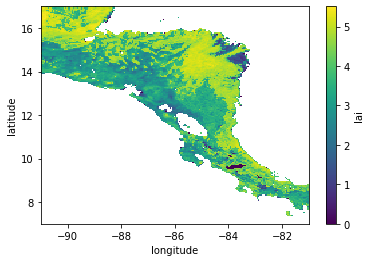

In [78]:
test["lai"].plot()

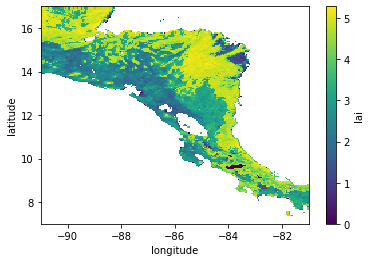

In [84]:
test2 = xr.open_dataset("../data_processed/ca_Jun-1985_Aug-1990_all_mlai_avhrr.nc")
test2["lai"].plot()

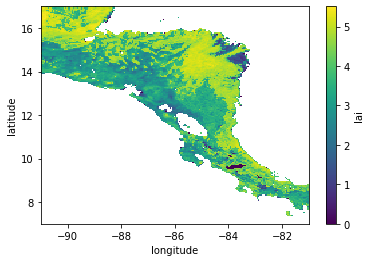

In [12]:
test3 = xr.open_dataset("../data_processed/ca_Jun-1985_Aug-1990_JJA_glass-mean_avhrr.nc")
test3["lai"].plot()

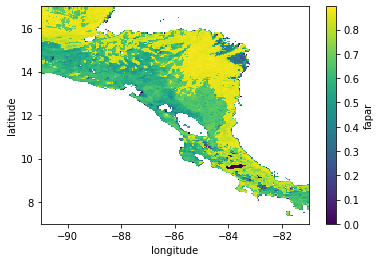

In [13]:
test3["fapar"].plot()

In [9]:
test4 = xr.open_dataset("../data_processed/wa_May-2005_Aug-2010_Feb_glass-mean_modis.nc")
test4

<xarray.Dataset>
Dimensions:    (longitude: 200, latitude: 100)
Coordinates:
  * longitude  (longitude) float64 113.0 113.1 113.1 113.2 ... 122.9 122.9 123.0
  * latitude   (latitude) float64 -30.03 -30.08 -30.13 ... -34.88 -34.93 -34.98
Data variables:
    lai        (latitude, longitude) float32 ...
    fapar      (latitude, longitude) float32 ...

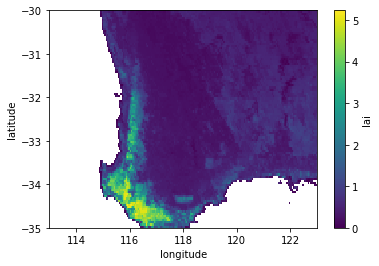

In [10]:
test4["lai"].plot()

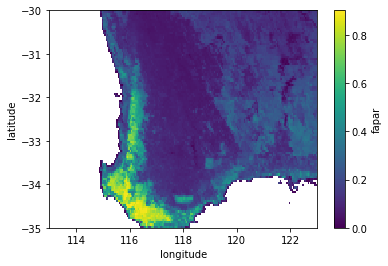

In [11]:
test4["fapar"].plot()

In [7]:
test5 = xr.open_dataset("../data_processed/wa_Jan-2020_Dec-2021_all_glass-mean_modis.nc")
test5

<xarray.Dataset>
Dimensions:    (longitude: 200, latitude: 100)
Coordinates:
  * longitude  (longitude) float64 113.0 113.1 113.1 113.2 ... 122.9 122.9 123.0
  * latitude   (latitude) float64 -30.03 -30.08 -30.13 ... -34.88 -34.93 -34.98
Data variables:
    lai        (latitude, longitude) float32 ...
    fapar      (latitude, longitude) float32 ...

In [7]:
test6 = xr.open_dataset("../data_processed/wa_May-1981_May-1982_all_glass-mean_avhrr.nc")
test6

<xarray.Dataset>
Dimensions:    (longitude: 200, latitude: 100)
Coordinates:
  * longitude  (longitude) float64 113.0 113.1 113.1 113.2 ... 122.9 122.9 123.0
  * latitude   (latitude) float64 -30.03 -30.08 -30.13 ... -34.88 -34.93 -34.98
Data variables:
    lai        (latitude, longitude) float32 ...
    fapar      (latitude, longitude) float32 ...

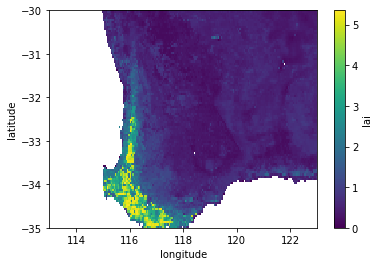

In [8]:
test6["lai"].plot()

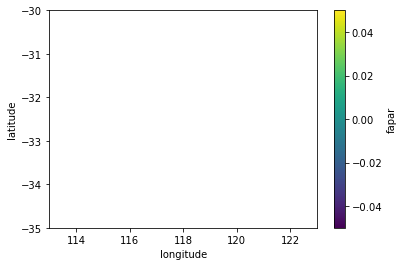

In [9]:
test6["fapar"].plot()

In [14]:
test7 = xr.open_dataset("../data_processed/ca_Aug-2021_Aug-2021_all_glass-mean_modis.nc")
test7

<xarray.Dataset>
Dimensions:    (longitude: 200, latitude: 200)
Coordinates:
  * longitude  (longitude) float64 -90.97 -90.92 -90.87 ... -81.12 -81.07 -81.02
  * latitude   (latitude) float64 16.97 16.92 16.87 16.82 ... 7.125 7.075 7.025
Data variables:
    lai        (latitude, longitude) float32 ...
    fapar      (latitude, longitude) float32 ...

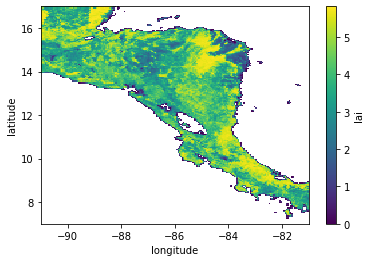

In [15]:
test7["lai"].plot()

In [ ]:
#     def obtain_mean_climatology_ds(var):
#         assert var in vars_glass, \
#             f"var must be one of: {vars_glass}"
#         files_all = glob(f"../data_raw/global_glass-{var}-{datasource}_8-day/" +
#                              f"global_glass-{var}-{datasource}*")
#         files_filtered = list(filter(filter_glass_files, files_all))
#         files_filtered.sort()
#         ds_mean = (xr.open_mfdataset(files_filtered, engine = "rasterio",
#                                     preprocess=preprocess_glass, parallel = True)
#                    .chunk(chunks = {"time": chunksize})
#                    .persist()
#                    .drop_vars("spatial_ref")
#                    .squeeze("band", drop=True)
#                    .rename({"band_data": var})
#                    .mean("time")
#                   )
#         return(ds_mean)
    
#     ds_mlai = obtain_mean_climatology_ds("lai")
#     ds_mfapar = obtain_mean_climatology_ds("fapar")
#     ds_glass_mean = xr.merge([ds_mlai, ds_mfapar])